In [101]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, FCC
import awkward as ak
import sys
ROOT_DIR="/home/prayag/coffeafcc/coffea-fcc-analyses/"
sys.path.append(ROOT_DIR+"analyzers")
import ReconstructedParticle
import fastjet
import hist
from coffea.analysis_tools import PackedSelection

In [102]:
fcc = FCC.get_schema()
events = NanoEventsFactory.from_root(
    '../../data/wzp6_ee_mumuH_Hbb_ecm240/events_159112833.root:events',
    schemaclass=fcc,
    # entry_stop=10000,
    metadata={'dataset':'ZH'},
    delayed=True,
    uproot_options={"filter_name": lambda x : "PARAMETERS" not in x}
).events()

In [103]:
events.fields

['CalorimeterHits',
 'EFlowNeutralHadron',
 'EFlowNeutralHadron_0',
 'EFlowNeutralHadron_1',
 'EFlowNeutralHadronidx0',
 'EFlowNeutralHadronidx1',
 'EFlowNeutralHadronidx2',
 'EFlowPhoton',
 'EFlowPhoton_0',
 'EFlowPhoton_1',
 'EFlowPhotonidx0',
 'EFlowPhotonidx1',
 'EFlowPhotonidx2',
 'EFlowTrack',
 'EFlowTrack_0',
 'EFlowTrack_1',
 'EFlowTrack_2',
 'EFlowTrackidx0',
 'EFlowTrackidx1',
 'Electronidx0',
 'Jet',
 'Jetidx0',
 'Jetidx1',
 'Jetidx2',
 'Jetidx3',
 'Jetidx4',
 'Jetidx5',
 'MCRecoAssociations',
 'MissingET',
 'MissingETidx0',
 'MissingETidx1',
 'MissingETidx2',
 'MissingETidx3',
 'MissingETidx4',
 'MissingETidx5',
 'Muonidx0',
 'Particle',
 'ParticleIDs',
 'ParticleIDs_0',
 'Particleidx0',
 'Particleidx1',
 'Photonidx0',
 'ReconstructedParticles',
 'ReconstructedParticlesidx0',
 'ReconstructedParticlesidx1',
 'ReconstructedParticlesidx2',
 'ReconstructedParticlesidx3',
 'ReconstructedParticlesidx4',
 'ReconstructedParticlesidx5',
 'TrackerHits',
 'TrackerHits_0']

In [104]:
# #################################
# #Begin the processor definition #
# #################################
# class jetclustering(processor.ProcessorABC):
#     '''
#     Create jets with ee_kt algorithm and form dijets (Higgs --> bb)
#     Create Z candidates from two leptons (Z --> ll)
#     '''
#     def __init__(self, *args, **kwargs):
#         pass

#     def process(self,events):

#         #Create a Packed Selection object to get a cutflow later
#         cut = PackedSelection()
#         cut.add('No cut', dak.ones_like(dak.num(get(events,'ReconstructedParticles','energy'),axis=1),dtype=bool))

#         # Selection 0 : No Cut (example)bb
#         sel0_ocl = cut.cutflow(*cut.names).yieldhist()
#         sel0_events = events

#         # Filter out any event with no reconstructed particles and generate Reconstructed Particle Attributes
#         #ak.mask preserves array length
#         at_least_one_recon = dak.num(get(events,'ReconstructedParticles','energy'), axis=1) > 0
#         good_events = dak.mask(events,at_least_one_recon)
#         cut.add('At least one Reco Particle', at_least_one_recon)

#         # Selection 1 : No Cut and At least one Reco Particle
#         sel1_ocl = cut.cutflow(*cut.names).yieldhist()
#         sel1_events = good_events

#         #Prepare output
#         #Choose the required histograms and their assigned variables to fill
#         names = plot_props.columns.to_list()
#         vars_sel0 = [get(sel0_events,'ReconstructedParticles','energy')]
#         vars_sel1 = [get(sel1_events,'ReconstructedParticles','energy')]

#         Output = {
#             'histograms': {
#                 'sel0':{name:get_1Dhist(name,var,flatten=True) for name,var in zip(names,vars_sel0)},
#                 'sel1':{name:get_1Dhist(name,var,flatten=True) for name,var in zip(names,vars_sel1)}
#             },
#             'cutflow': {
#                 'sel0': {'Onecut':sel0_ocl[0],'Cutflow':sel0_ocl[1],'Labels':sel0_ocl[2]},
#                 'sel1': {'Onecut':sel1_ocl[0],'Cutflow':sel1_ocl[1],'Labels':sel1_ocl[2]}
#             }
#         }
#         return Output

#     def postprocess(self, accumulator):
#         pass


In [105]:
Muons = events.ReconstructedParticles.match_collection(events.Muonidx0)
Z = ReconstructedParticle.resonanceBuilder(Muons, 91.0)
Recoil = ReconstructedParticle.recoilBuilder(Z, 240.0)
z_cuts = PackedSelection()
jet_cuts = PackedSelection()

In [106]:
#Define Selections
sel_p_gt_25_Muons = Muons.p > 25.0

sel_n_e_0_Muons = ak.num(Muons, axis=1) == 0
sel_n_gte_2_Muons = ak.num(Muons, axis=1) >= 2

sel_m_gt_70_Z = Z.m > 70.0
sel_m_lt_100_Z = Z.m < 100.0

sel_p_gt_20_Z = Z.p > 20.0
sel_p_lt_70_Z = Z.p < 70.0

sel_m_gt_120_Recoil = Recoil.m > 120.0
sel_m_lt_140_Recoil = Recoil.m > 140.0

# Add the selections to the cuts Packed Selection
z_cuts.add("p_gt_25_Muons", ak.all(sel_p_gt_25_Muons, axis=1))
z_cuts.add("n_gte_2_Muons", sel_n_gte_2_Muons)
z_cuts.add("m_gt_70_Z", sel_m_gt_70_Z)
z_cuts.add("m_lt_100_Z", sel_m_lt_100_Z)
z_cuts.add("p_gt_20_Z", sel_p_gt_20_Z)
z_cuts.add("p_lt_70_Z", sel_p_lt_70_Z)
z_cuts.add("m_gt_120_Recoil", sel_m_gt_120_Recoil)
z_cuts.add("m_lt_140_Recoil", sel_m_lt_140_Recoil)
jet_cuts.add("n_e_0_Muons", sel_n_e_0_Muons)

In [107]:
# Calculate the final variables
Good_Z = Z[z_cuts.all()]
Good_Recoil = Recoil[z_cuts.all()]

In [108]:
rps_no_mu = events.ReconstructedParticles[sel_n_e_0_Muons]
pseudo_jets = ak.zip(
    {
    'px':rps_no_mu.px,
    'py':rps_no_mu.py,
    'pz':rps_no_mu.pz,
    'E':rps_no_mu.E
    },
    with_name="Momentum4D",
    behavior=fcc.behavior()
)
jetdef = fastjet.JetDefinition0Param(fastjet.ee_kt_algorithm)
# Requirements: 
# [Done] arg_exclusive = 2
# [    ] arg_cut = 2 i.e., N jets for m_exclusive
# [    ] arg_sorted = 0 i.e., p_T ordering
# [    ] arg_recombination = 10 i.e., E0_scheme : Special for FCCAnalyses
jetdef.set_recombination_scheme(0) # E scheme
#jetdef.description()
cluster = fastjet.ClusterSequence(pseudo_jets, jetdef)
jet_constituents = cluster.constituents()
jets = cluster.exclusive_jets(2)
dijets = ak.sum(jets, axis=1)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f862dbfc080>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

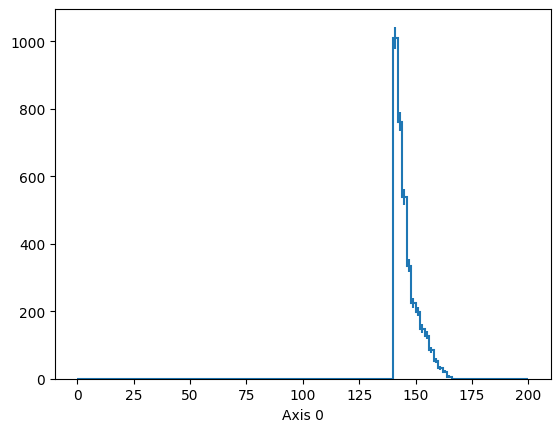

In [110]:
hist.Hist.new.Reg(100,0,200).Double().fill(Good_Recoil.m.compute()).plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f8666daf020>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

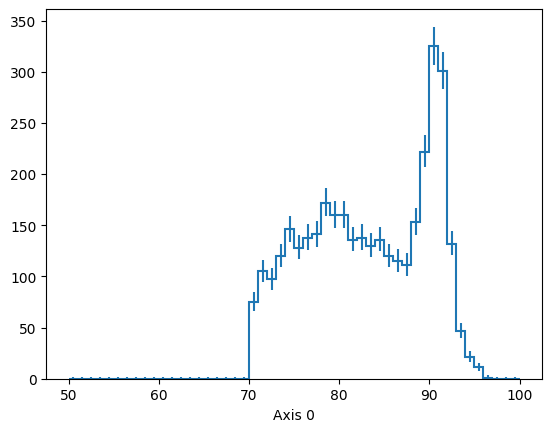

In [111]:
hist.Hist.new.Reg(50,50,100).Double().fill(Good_Z.m.compute()).plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f862ab212b0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

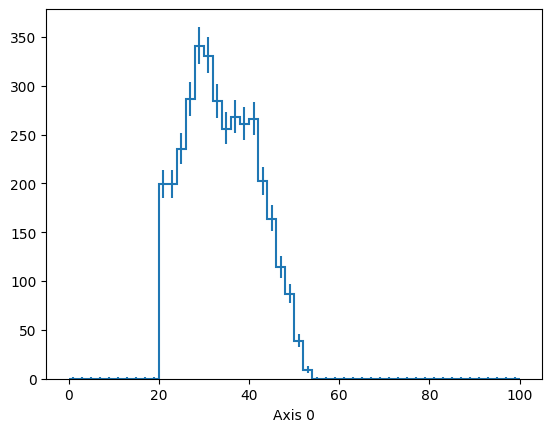

In [112]:
hist.Hist.new.Reg(50,0,100).Double().fill(Good_Z.p.compute()).plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f85c0fe12b0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

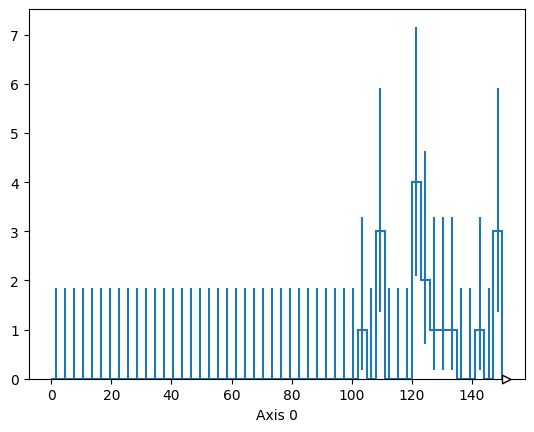

In [113]:
hist.Hist.new.Reg(50,00,150).Double().fill(dijets.m.compute()).plot()